# Is amplitude self-calibration viable and necessary?

This test run on W51-E B6, which looks quite bad even after phase self-calibration and a reasonably deep masked clean.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy import units as u

In [3]:
import pylab as pl
pl.rcParams['figure.figsize'] = (20,8)

In [4]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show
from spectral_cube import SpectralCube

In [5]:
import os
os.chdir("/lustre/naasc/projects/ALMA_IMF/2017.1.01355.L/")

In [6]:
from casatasks import gaincal

In [7]:
import selfcal_heuristics

In [8]:
caltable = 'W51-E_B6_uid___A001_X1296_X215_continuum_merged_7M12M_amp5_inf.cal/'
msfile = 'W51-E_B6_uid___A001_X1296_X215_continuum_merged_7M12M_selfcal.ms/'
if not os.path.exists(caltable):
    gaincal(vis=msfile,
            caltable=caltable,
            solint='inf',
            calmode='ap',)

In [9]:
okfields,notokfields = selfcal_heuristics.goodenough_field_solutions(caltable,
                                                                     minsnr=5)
print(okfields, notokfields)

[7, 17, 18, 21, 22, 23, 25, 26, 27, 30, 31, 32] [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 24, 28, 29, 33, 34, 35, 36, 37]


In [10]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [11]:
msmd = casatools.msmetadata()

In [12]:
with CasaTable(caltable) as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    amp = np.abs(data)
    angle = np.angle(data)
    time = tb.getcol('TIME')
    snr = tb.getcol('SNR') 
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')
    fieldid = tb.getcol('FIELD_ID')
    data = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data['ANGLE'] = angle
data['AMP'] = amp

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [13]:
fids = np.unique(data['FIELD_ID'])
print(fids)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37]


In [14]:
oids = np.unique(data['OBSERVATION_ID'])
print(oids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [15]:
spwids = np.unique(data['SPECTRAL_WINDOW_ID'])
print(spwids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77]


In [16]:
# which observations contain which fields?
for oid in oids:
    oid_match = data['OBSERVATION_ID'] == oid
    has_fid = [fid for fid in fids if np.any((data['FIELD_ID'] == fid) & oid_match)]
    print(f"OID {oid} has fields {has_fid}")

OID 0 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 1 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 2 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 3 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
OID 4 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 5 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 6 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 7 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 8 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 9 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 10 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 11 has fields [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OID 12 has fields [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


fid=11  mean=1.5066666611517519  median=1.4091010441724454  rms=0.3980314974749133
fid=12  mean=2.1109338179539447  median=2.0007352818254494  rms=1.0559493761561918
fid=13  mean=1.5999030766302877  median=1.5292568347597175  rms=0.3636494359956338
fid=15  mean=1.0776146907334516  median=0.9274913182195478  rms=0.5262248399098479
fid=16  mean=1.3165798474490293  median=1.2774995153051436  rms=0.49415717465041786
fid=17  mean=1.1376403670245188  median=1.076909974875429  rms=0.31822634296114743
fid=18  mean=1.0512533421494679  median=1.0003705687113977  rms=0.3700720670483723
fid=19  mean=3.136254630048467  median=1.7127455439701433  rms=3.221962191079505
fid=20  mean=1.0928698334563922  median=1.0446252183502676  rms=0.35331022995428535
fid=21  mean=1.0413745717930527  median=0.9834366308287744  rms=0.3354775851966515
fid=22  mean=0.9782680601929673  median=0.8895665038115488  rms=0.3696936521562569
fid=23  mean=1.0172418338542084  median=0.9379816183319213  rms=0.36246327339030915
fid

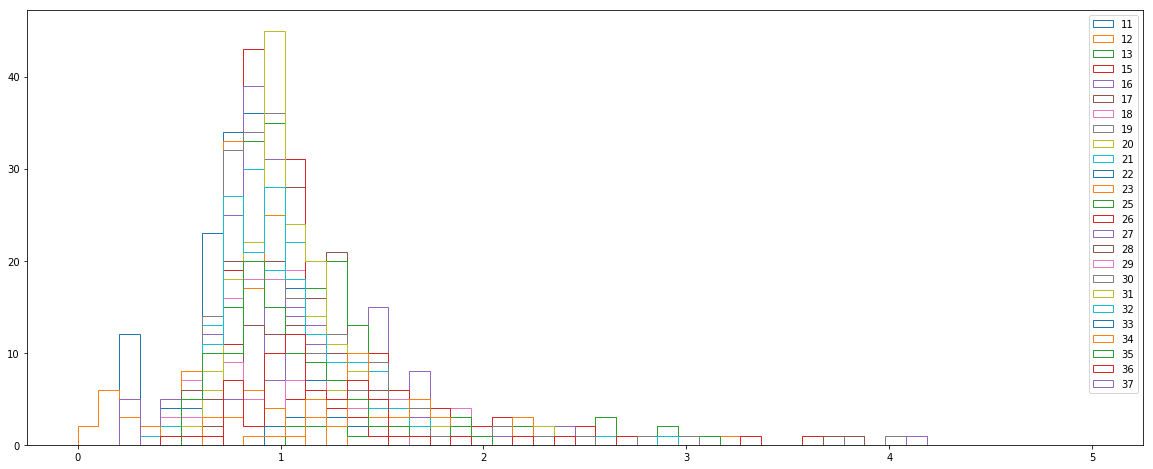

In [17]:
pl.clf()
fldstats = {}
for ii,fid in enumerate(np.unique(fieldid[obsid==2])):
    msk = (obsid==2) & (spwid == 16) & (fieldid==fid)
    if np.any(msk):
        dd = amp[0,0,msk]
        ok = (dd!=0) & (dd!=1)
        pl.hist(dd[ok], bins=np.linspace(0,5), histtype='step', label=f"{fid}")
        print(f"fid={fid}  mean={dd[ok].mean()}  median={np.median(dd[ok])}  rms={dd[ok].std()}")
        fldstats[fid] = [dd[ok].mean(), np.median(dd[ok]), dd[ok].std()]
pl.legend(loc='best')

In [18]:
fieldOKmask = np.isin(data['FIELD_ID'], okfields)

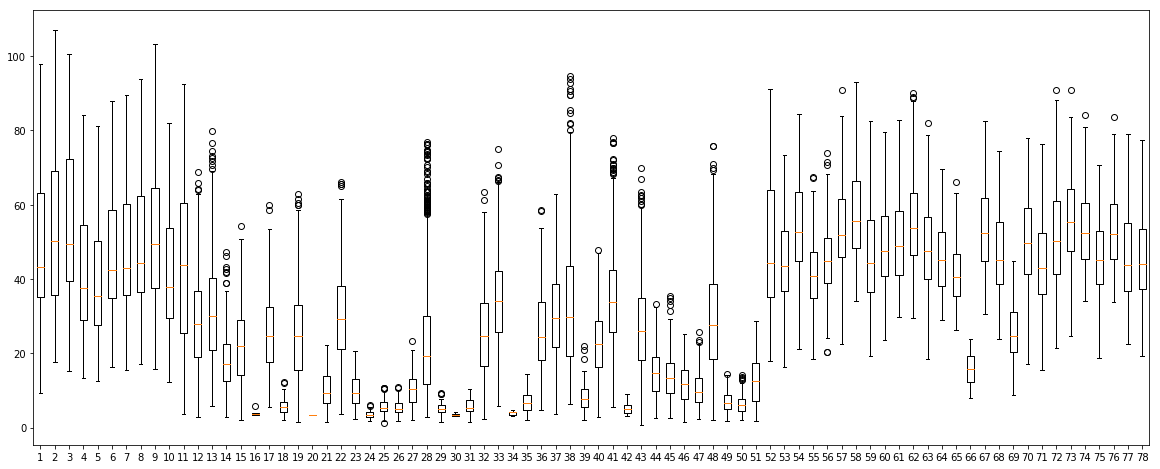

In [19]:
OK = data['SNR'] != 0

toplot = [data['SNR'][0,0, fieldOKmask & (OK[0,0,:]) & (data['ANTENNA1'] == ant)]
          for ant in np.unique(data['ANTENNA1'])]
toplot = [x for x in toplot if len(x) > 0]

_ = pl.boxplot(toplot)

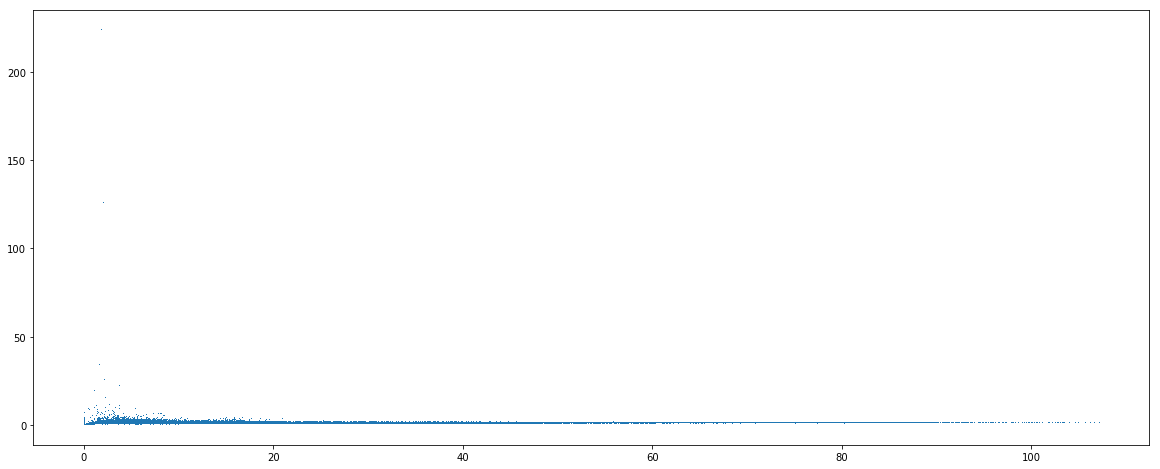

In [20]:
pl.plot(data['SNR'][0,0,:], data['AMP'][0,0,:], ',')

In [21]:
msmd.open(msfile)
antobs = {}
obsid = data['OBSERVATION_ID']
for oid in np.unique(obsid):
    antids = np.unique(data['ANTENNA1'][(obsid==oid) & (OK[0,0,:])])
    antnames = {k:v for k,v in zip(antids, msmd.antennanames(antids))}

    center = (np.mean([msmd.antennaoffset(k)['latitude offset']['value'] for k in antnames]),
              np.mean([msmd.antennaoffset(k)['longitude offset']['value'] for k in antnames]),)
    print(oid, center)
    
    antdist = {k:((msmd.antennaoffset(k)['latitude offset']['value']-center[0])**2 + (msmd.antennaoffset(k)['longitude offset']['value']-center[1])**2)**0.5
               for k in antnames}
    antloc = {k:(msmd.antennaoffset(k)['latitude offset']['value'], msmd.antennaoffset(k)['longitude offset']['value'])
               for k in antnames}

    antobs[oid] = {'antnames': antnames,
                   'antdist': antdist,
                   'antloc': antloc}
msmd.close()
antdist = {(ant,oid): antobs[oid]['antdist'][ant] for oid in antobs for ant in antobs[oid]['antnames']}
antnames = {(ant,oid): antobs[oid]['antnames'][ant] for oid in antobs for ant in antobs[oid]['antnames']}

0 (-548.91486467752088, 8.5623289140286687)
1 (-548.91486467752088, 8.5623289140286687)
2 (-669.19146495239022, 36.965444670852847)
3 (-716.00474893953617, 37.764400862761519)
4 (-547.23154852781931, 9.5137001124720832)
5 (-549.96290716449869, 7.4930404402901063)
6 (-547.96892682463579, 8.1983687033505976)
7 (-549.96290716449869, 7.4930404402901063)
8 (-549.96290716449869, 7.4930404402901063)
9 (-549.47660534550891, 9.2764176760223389)
10 (-553.03430134639711, 9.7178709631026212)
11 (-549.93042133846939, 9.7802891867571766)
12 (-708.34688825572312, 22.236483871868082)


In [22]:
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

antenna=CM01 oid=0 dist=  21.1 mean=     47.52 median=     46.76 std=      6.88 amp mean=      1.07 amp std=      0.09 angle_rms=      0.35
antenna=CM02 oid=0 dist=   6.5 mean=     47.78 median=     45.26 std=     10.35 amp mean=      0.97 amp std=      0.11 angle_rms=      0.43
antenna=CM04 oid=0 dist=  26.9 mean=     37.35 median=     35.97 std=      5.50 amp mean=      1.01 amp std=      0.08 angle_rms=      0.32
antenna=CM06 oid=0 dist=  20.6 mean=     34.48 median=     34.31 std=      7.91 amp mean=      0.97 amp std=      0.08 angle_rms=      0.81
antenna=CM07 oid=0 dist=  20.6 mean=     44.33 median=     43.42 std=      7.18 amp mean=      1.00 amp std=      0.07 angle_rms=      0.80
antenna=CM08 oid=0 dist=  17.5 mean=     45.79 median=     45.44 std=     11.06 amp mean=      0.92 amp std=      0.10 angle_rms=      0.81
antenna=CM09 oid=0 dist=  22.7 mean=     44.40 median=     44.80 std=     10.53 amp mean=      1.04 amp std=      0.09 angle_rms=      0.80
antenna=CM10 oid=0 d

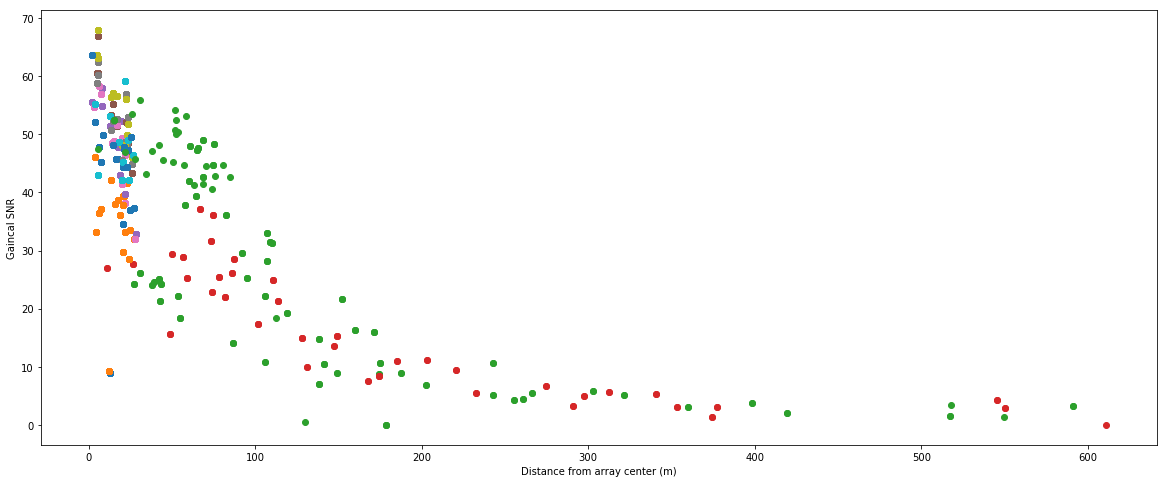

In [24]:
uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Gaincal SNR")    

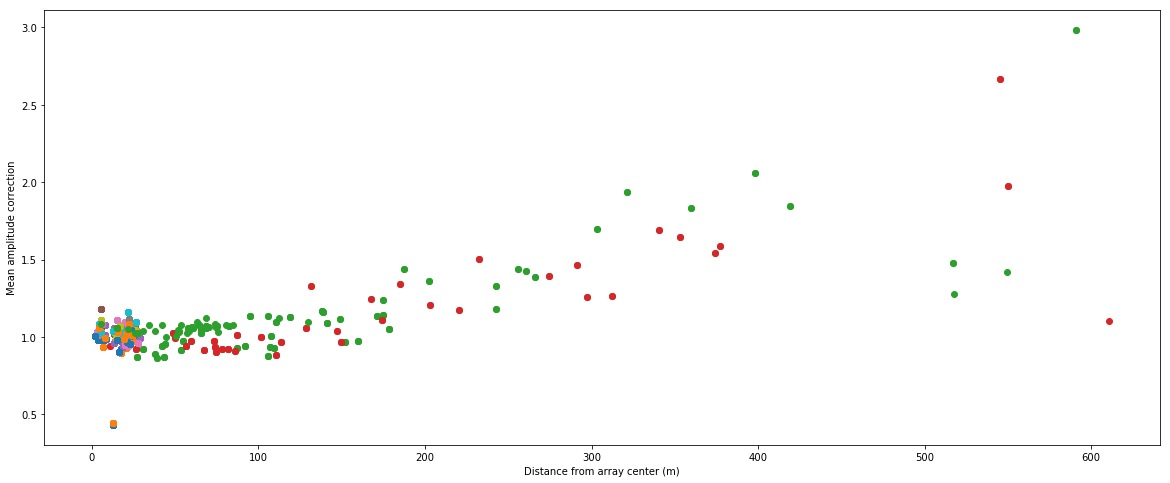

In [25]:
uoids = np.unique(data['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")

In [26]:

with CasaTable(caltable) as tb:
    amp = np.abs(tb.getcol('CPARAM'))
    angle = np.angle(tb.getcol('CPARAM'))
    data6 = {col: tb.getcol(col) for col in tb.colnames() if col not in ("WEIGHT",)}
data6['ANGLE'] = angle
data6['AMP'] = amp

In [ ]:
data=data6
fieldOKmask = np.isin(data['FIELD_ID'], okfields)
OK = data['SNR'] != 0
antstats = {}
for oid in np.unique(data['OBSERVATION_ID']):
    for antid in np.unique(data['ANTENNA1']):
        msk = (data['ANTENNA1'] == antid) & (OK[0,0,:]) & fieldOKmask & (data['OBSERVATION_ID'] == oid)
        if np.any(msk) and (antid, oid) in antnames:
            dat = data['SNR'][1,0, msk]
            ang = data['ANGLE'][1,0, msk]
            amp = data['AMP'][1,0, msk]
            print(f"antenna={antnames[(antid,oid)]} oid={oid} dist={antdist[(antid,oid)]:6.1f} "
                  f"mean={dat.mean():10.2f} median={np.median(dat):10.2f} "
                  f"std={dat.std():10.2f} amp mean={amp.mean():10.2f} "
                  f"amp std={amp.std():10.2f} angle_rms={ang.std()*180/np.pi:10.2f}")
            antstats[(antid,oid)] = {'mean':dat.mean(),
                               'median':np.median(dat),
                               'std': dat.std(),
                               'angle_rms': ang.std(),
                               'amp_mean': amp.mean(),
                               'amp_std': amp.std(),
                              }

In [ ]:
uoids = np.unique(data6['OBSERVATION_ID'])
for oid in uoids:
    pl.plot([antdist[(ant,oid)] for ant,_ in antstats  if (ant,oid) in antstats],
            [antstats[(ant,oid)]['amp_mean'] for ant,_ in antstats  if (ant,oid) in antstats],
            'o')
pl.xlabel("Distance from array center (m)")
pl.ylabel("Mean amplitude correction")